In [21]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform
from project.utils import collatev2
from project.utils import compute_statistics
from project.evaluation import isa_rpn_metric, Tracker

In [22]:
### UPDATE RPN WEIGHTS HERE BEFORE TRAINING

rpn_weights = f'fold/Nov_22_2024_221537/fold_1/rpn_fold1.pt'

In [23]:
rpn_tk = Tracker()

### Monitoring and CUDA Setup


In [24]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/rpn_vit_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_22_2024_232927'

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
rpn_tk.date = rn
rpn_tk.logfile = f'rpn_vit_{dte}.log'
rpn_tk.device = device

### Config for RPN and ViT Fitter


In [27]:
from project.model import RPN, ISAVIT

rpn_config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        global_context=True,
        nh=4,
        pretrained=False
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 50,
    'loss': nn.SmoothL1Loss(),
    'lr': 0.0001
}

324


d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [28]:
rpn_tk.model = 'RPN'
rpn_tk.model_hyperparams = rpn_config['model'].config
rpn_tk.uses_resnet = rpn_config['model'].config['pretrained']
rpn_tk.optimizer = f"{rpn_config['optimizer']}"
rpn_tk.epochs = rpn_config['epochs']
rpn_tk.loss = f"{rpn_config['loss']}"
rpn_tk.lr = rpn_config['lr']

### Dataset Loading


In [29]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [30]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
rpn_tk.only_cmb_slices = True
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,8,1,1,1,928.405273,35
1,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,9,1,1,1,928.405273,35
2,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,11,1,1,1,928.405273,35
3,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,12,1,1,1,928.405273,35
4,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,241.000000,36
360,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,26,1,1,3,241.000000,36
361,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,24,1,1,3,448.000000,39
362,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,448.000000,39


### Preprocessing and Train-Test Split Function


In [31]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                 rpn_tracker=rpn_tk,
                ):
    if cohort == 1:
        rpn_tracker.cohort1 = True
    if cohort == 2:
        rpn_tracker.cohort2 = True
    if cohort == 3:
        rpn_tracker.cohort3 = True
    
    rpn_tracker.test_size = test_size
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

In [32]:
def fix_coords(x1, y1, x2, y2):
    x_min = min(x1, x2)
    x_max = max(x1, x2)
    y_min = min(y1, y2)
    y_max = max(y1, y2)
    
    return x_min, x_max, y_min, y_max

def direction_calculations(gtruth_bbox, pred_bbox):
    x1_pred, y1_pred, x2_pred, y2_pred = pred_bbox.squeeze(0)
    x1_gtruth, y1_gtruth, x2_gtruth, y2_gtruth = gtruth_bbox.squeeze(0)
    
    x1_pred, y1_pred, x2_pred, y2_pred = fix_coords(x1_pred, y1_pred, x2_pred, y2_pred)
    
    x1_gtruth, y1_gtruth, x2_gtruth,y2_gtruth = fix_coords(x1_gtruth, y1_gtruth, x2_gtruth,y2_gtruth)
    
    delta_x_left = abs(x1_pred - x1_gtruth)
    delta_x_right = abs(x2_pred - x2_gtruth)
    delta_y_top = abs(y1_pred - y1_gtruth)
    delta_y_bottom = abs(y2_pred - y2_gtruth)
    
    center_pred_x = (x1_pred + x2_pred) / 2
    center_pred_y = (y1_pred + y2_pred) / 2
    center_gtruth_x = (x1_gtruth + x2_gtruth) / 2
    center_gtruth_y = (y1_gtruth + y2_gtruth) / 2
    
    delta_center_x = abs(center_pred_x - center_gtruth_x)
    delta_center_y = abs(center_pred_y - center_gtruth_y)
    
    return {
        'delta_x_left': delta_x_left,
        'delta_x_right': delta_x_right,
        'delta_y_top': delta_y_top,
        'delta_y_bottom': delta_y_bottom,
        'delta_center_x': delta_center_x,
        'delta_center_y': delta_center_y,
    } 

### RPN Fitter


In [33]:
from project import Fitter

In [34]:
class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        counter = 0
        for batch in train_loader:
            # self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)/300
                y = self.model(x, target)

                iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                evaluation_metric['iou_score'].append(iou_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                # self.log(f'EVAL METS: {iou_score, precision_score, recall_score, f1_score}')
                Y.append(y)
                T.append(masks[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            # if counter % len(batch) == 0:
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        
        return loss_history, evaluation_metric
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    x = slices.squeeze(1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/300
                    y = self.model(x, target)
                    
                    error_metrics = direction_calculations(gtruth_bbox=masks[target], pred_bbox=y)
                    
                    iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                    evaluation_metric['iou_score'].append(iou_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    Y.append(y)
                    T.append(masks[target])
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        self.log(f'\nValidation Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        return loss_history, evaluation_metric, error_metrics
                

### Train-Test Split


In [35]:
rpn_t1, rpn_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=True
)

rpn_t3, rpn_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=True
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [36]:
from torch.utils.data import ConcatDataset

rpn_train_set = ConcatDataset([rpn_t1, rpn_t3])
rpn_test_set = ConcatDataset([rpn_v1, rpn_v3])

print(f'RPN Train Set Size: {rpn_train_set}')
print(f'RPN Test Set Size: {rpn_test_set}')

RPN Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000002160D383010>
RPN Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000002160D314090>


In [37]:
batchs = 20

rpn_test_dataloader = DataLoader(
    rpn_test_set,
    shuffle=True,
    batch_size=batchs,
    collate_fn=collatev2
)

### K-Fold Cross Validation


In [38]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [39]:
rpn_test_iou = []
rpn_test_precision = []
rpn_test_recall = []
rpn_test_f1 = []

In [40]:
rpn_fold_metrics = []
rpn_direction_metrics = []

fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(rpn_train_set)):
    print(f'Fold {i + 1}/{5}')
    logger.info(f'################################### Fold {i+1}/5 ###################################')
    
    # RPN
    rpn_config['model'] = RPN(**rpn_tk.model_hyperparams).to(device)
    rpn_config['model'].load_state_dict(torch.load(rpn_weights))
    
    rpn_fitter = RPNFitter(rpn_config, logger=logger)
    
    rpn_h, rpn_mh, rpn_dm = rpn_fitter.validation(rpn_test_dataloader)
    rpn_valmets = pd.DataFrame(rpn_mh)
    rpn_mets = rpn_valmets.mean()
    
    rpn_dm['fold'] = i+1
    rpn_direction_metrics.append(rpn_dm)
    rpn_test_iou.append(rpn_mets.iou_score)
    rpn_test_precision.append(rpn_mets.precision_score)
    rpn_test_recall.append(rpn_mets.recall_score)
    rpn_test_f1.append(rpn_mets.f1_score)

    

INFO:kess:################################### Fold 1/5 ###################################


Fold 1/5
324


d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
d:\Programming Files\Python\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.23160219466999957
INFO:kess:Avg Precision: 0.2508584978549104
INFO:kess:Avg Recall: 0.7436468554170508
INFO:kess:Avg F1: 0.3580630139300698
INFO:kess:################################### Fold 2/5 ###################################


Fold 2/5
324


INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.23160219466999957
INFO:kess:Avg Precision: 0.2508584978549104
INFO:kess:Avg Recall: 0.7436468554170508
INFO:kess:Avg F1: 0.3580630139300698
INFO:kess:################################### Fold 3/5 ###################################


Fold 3/5
324


INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.23160219466999957
INFO:kess:Avg Precision: 0.2508584978549104
INFO:kess:Avg Recall: 0.7436468554170508
INFO:kess:Avg F1: 0.3580630139300698
INFO:kess:################################### Fold 4/5 ###################################


Fold 4/5
324


INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.23160219466999957
INFO:kess:Avg Precision: 0.2508584978549104
INFO:kess:Avg Recall: 0.7436468554170508
INFO:kess:Avg F1: 0.3580630139300698
INFO:kess:################################### Fold 5/5 ###################################


Fold 5/5
324


INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.23160219466999957
INFO:kess:Avg Precision: 0.2508584978549104
INFO:kess:Avg Recall: 0.7436468554170508
INFO:kess:Avg F1: 0.3580630139300698


In [41]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Directional Errors Visualization


> rpn_direction_metrics[fold]

> rpn_direction_metrics[fold]['delta_x_left] == tensor(0.2041, device='cuda:0')


In [42]:
df_direction = pd.DataFrame(columns=[
    'delta_x_left', 'delta_x_right', 'delta_y_top', 'delta_y_bottom', 'delta_center_x', 'delta_center_y', 'fold'
])

In [43]:
dir_cols= list(rpn_direction_metrics[0].keys())
df_direction = pd.DataFrame(columns=dir_cols)

for fold in range(len(rpn_direction_metrics)):
    values = [float(value.item()) if isinstance(value, torch.Tensor) else int(value) for value in rpn_direction_metrics[fold].values()]
    df_direction.loc[len(df_direction)] = values

In [44]:
df_direction.set_index('fold', inplace=True)
df_direction

,delta_x_left,delta_x_right,delta_y_top,delta_y_bottom,delta_center_x,delta_center_y
fold,,,,,,
1.0,0.146826,0.238235,0.127581,0.032175,0.192530,0.047703
2.0,0.012576,0.326300,0.145748,0.231637,0.156862,0.042944
3.0,0.012576,0.326300,0.145748,0.231637,0.156862,0.042944
4.0,0.113558,0.296304,0.432051,0.087231,0.091373,0.172410
5.0,0.067820,0.355153,0.420729,0.063489,0.143666,0.242109


In [45]:
df_ave_direction = df_direction.mean()
df_ave_direction

delta_x_left      0.070671
delta_x_right     0.308459
delta_y_top       0.254372
delta_y_bottom    0.129234
delta_center_x    0.148259
delta_center_y    0.109622
dtype: float64

In [46]:
df_std_direction = df_direction.std()
df_std_direction

delta_x_left      0.059994
delta_x_right     0.044430
delta_y_top       0.157257
delta_y_bottom    0.095499
delta_center_x    0.036623
delta_center_y    0.092495
dtype: float64

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

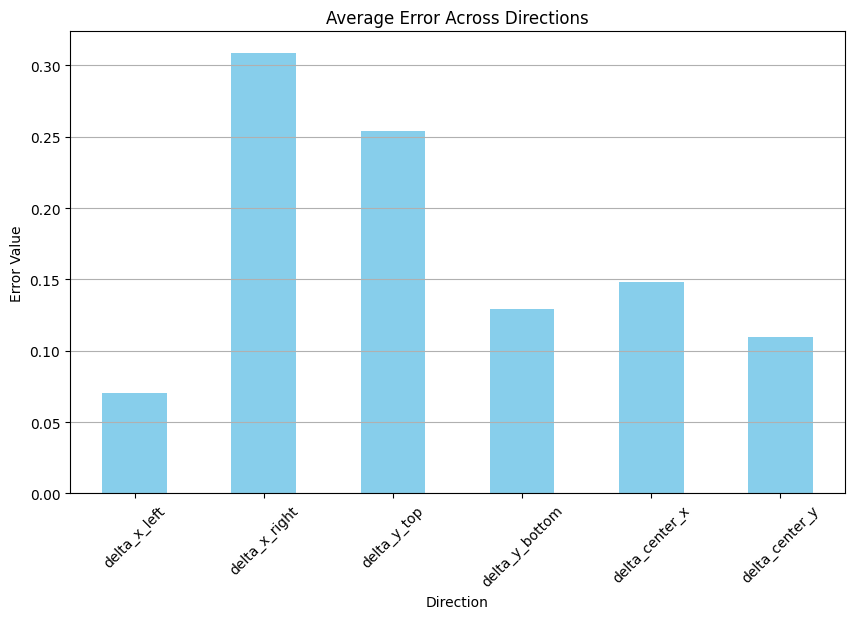

In [48]:
plt.figure(figsize=(10, 6))
df_ave_direction.plot(kind='bar', color='skyblue')
plt.title('Average Error Across Directions')
plt.ylabel('Error Value')
plt.xlabel('Direction')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

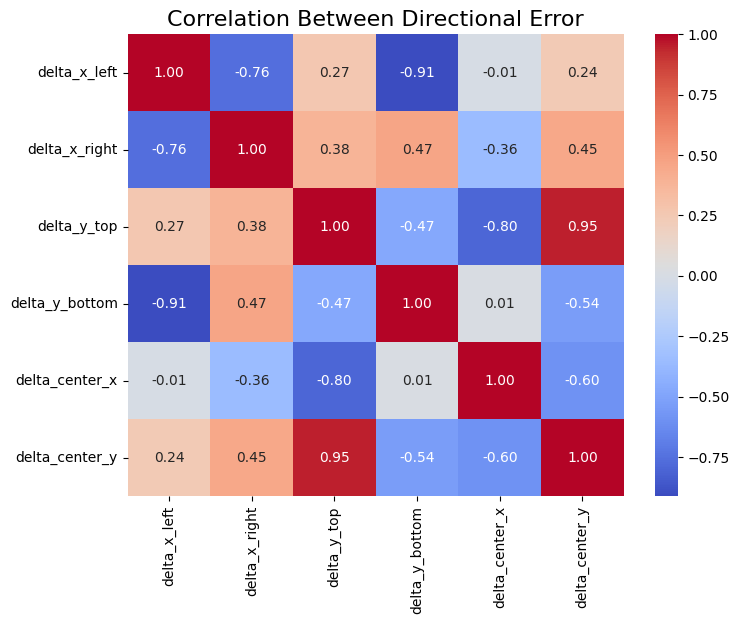

In [49]:
correlation = df_direction.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Directional Error', fontsize=16)
plt.show()

### Sample


#### RPN


In [50]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

In [51]:
len(next(iter(rpn_test_dataloader)))

19

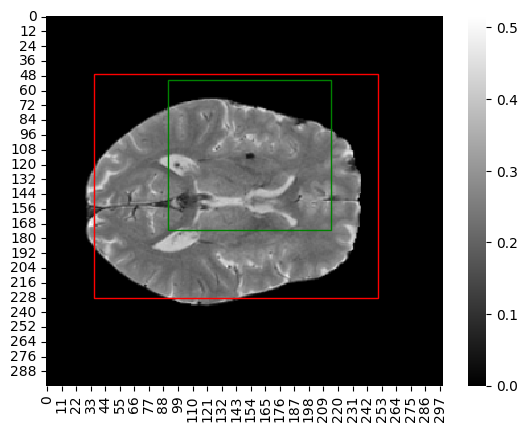

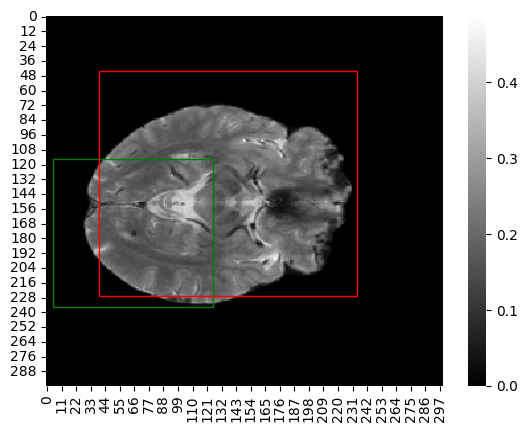

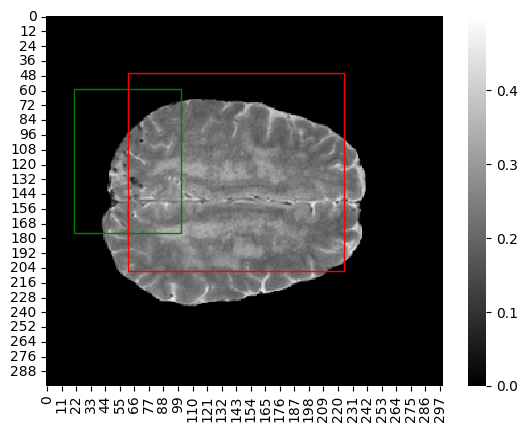

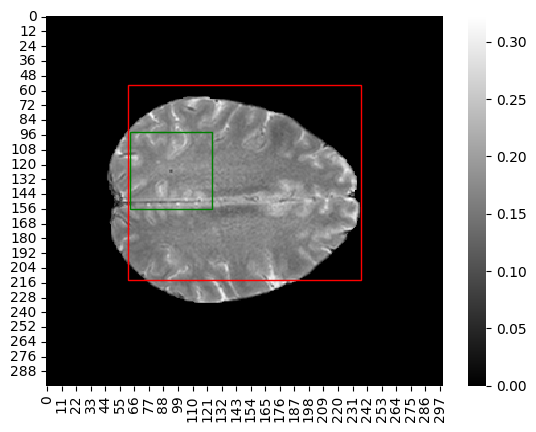

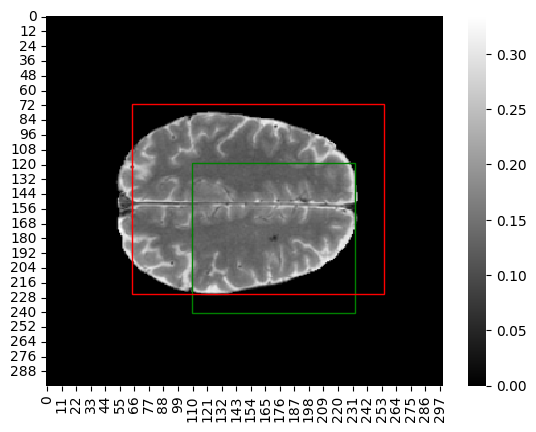

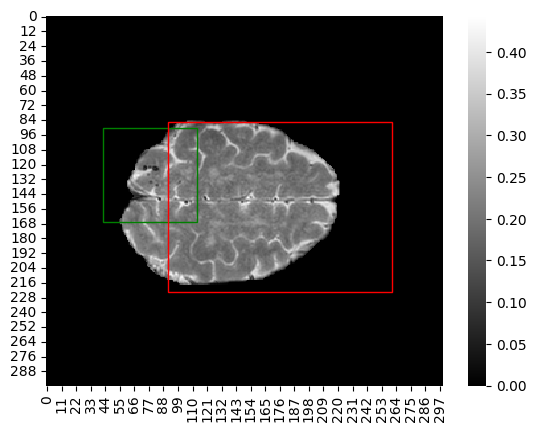

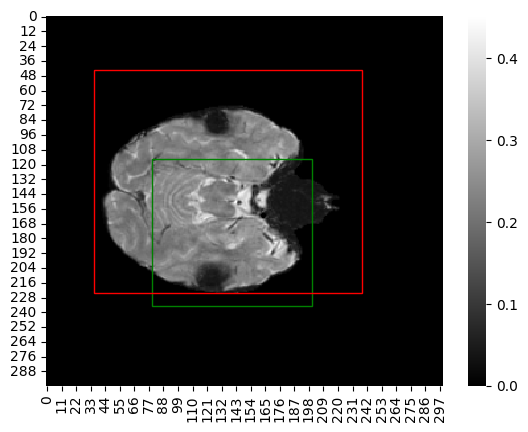

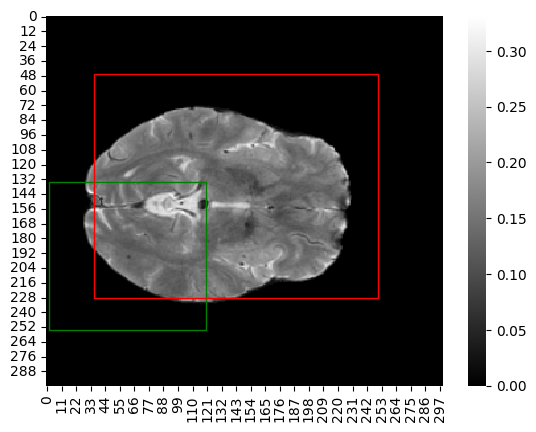

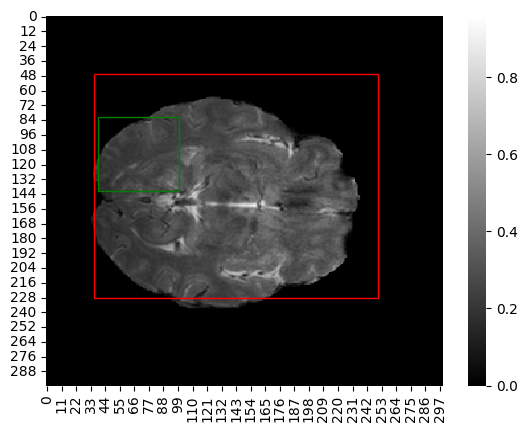

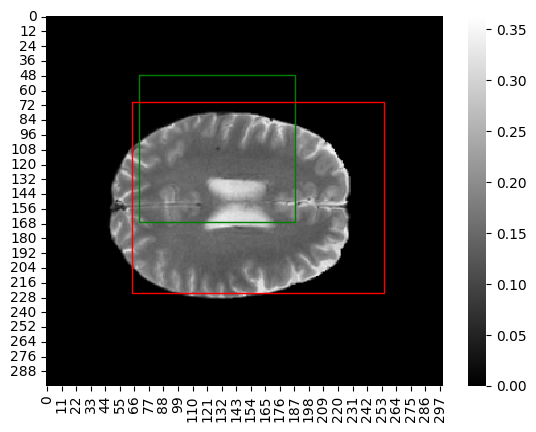

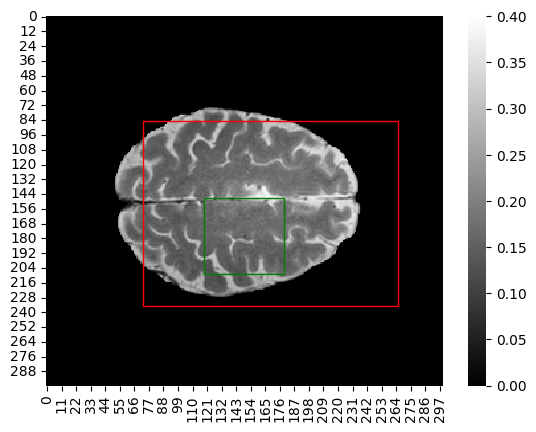

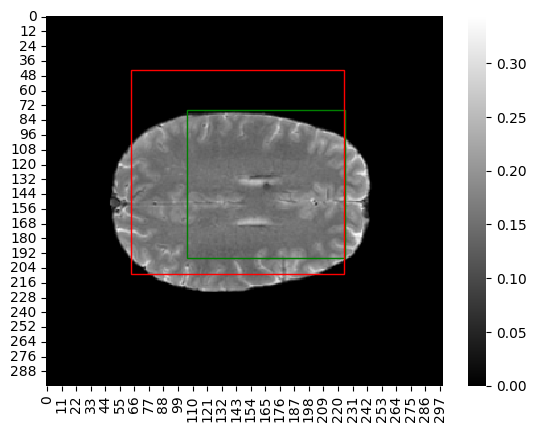

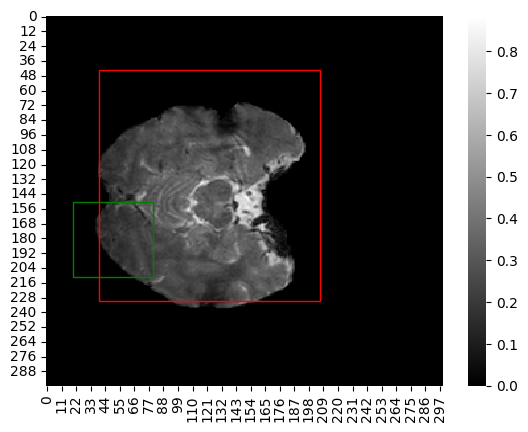

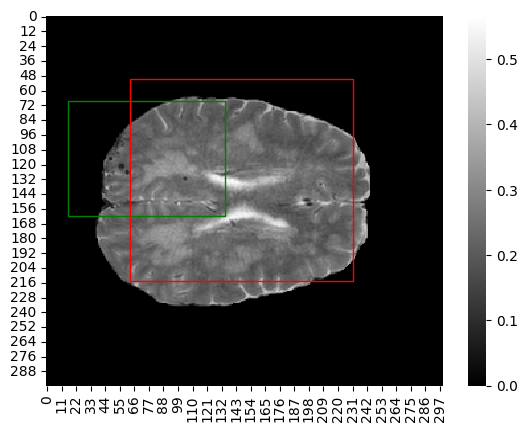

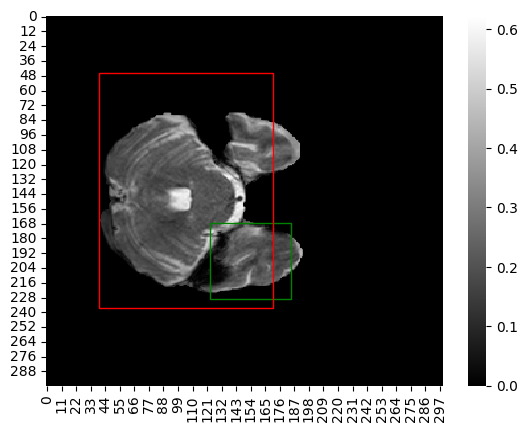

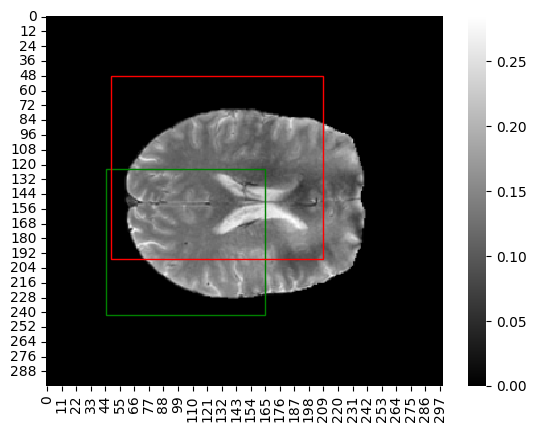

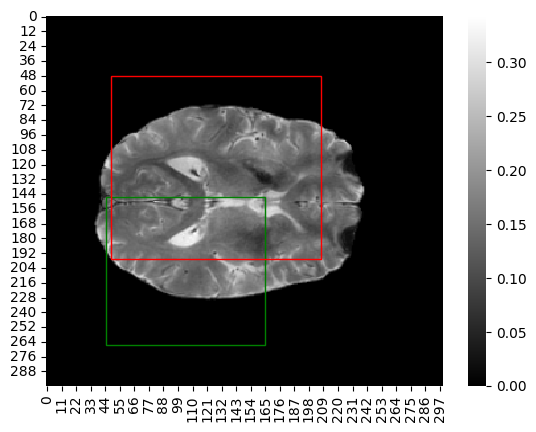

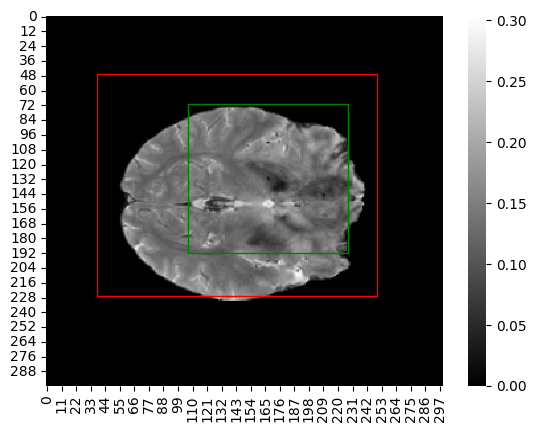

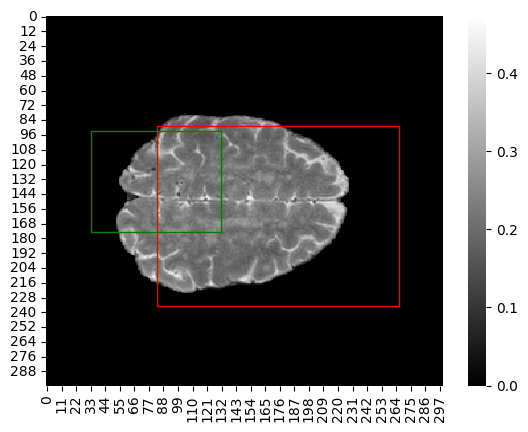

In [53]:
sample = next(iter(rpn_test_dataloader))

for i in range(len(next(iter(rpn_test_dataloader)))):
    rpn_slices, rpn_masks, rpn_target, rpn_case = sample[i]
    
    rpn_x = rpn_slices.squeeze(1).float().to(device)
    # rpn_x = rpn_slices.squeeze(1).repeat(1, 3, 1, 1).float().to(device)
    rpn_T = rpn_masks.squeeze(1).float().to(device)
    rpn_y = rpn_fitter.model(rpn_x, rpn_target)
    
    rpn_fitter.loss(rpn_y, rpn_T[rpn_target])
    rpn_bbox = rpn_masks[rpn_target].squeeze().cpu().long()
    rpn_y = (rpn_y*300).squeeze().detach().cpu().long()
    
    ax = sns.heatmap(rpn_x[rpn_target][0].squeeze().cpu(), cmap='gray')

    truth = patches.Rectangle(
        (rpn_bbox[0], rpn_bbox[1]),
        rpn_bbox[2] - rpn_bbox[0],
        rpn_bbox[3] - rpn_bbox[1],
        linewidth=1, edgecolor='g', facecolor='none'
    )

    pred = patches.Rectangle(
        (rpn_y[0], rpn_y[1]),
        rpn_y[2] - rpn_y[0],
        rpn_y[3] - rpn_y[1],
        linewidth=1, edgecolor='r', facecolor='none'
    )

    ax.add_patch(truth)
    ax.add_patch(pred)
    plt.show()

# Log Progress


In [54]:
rpn_tk.notes = '''
Global Context
'''

In [55]:
rpn_tk()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-11-22 23:29:27.262281,RPN,None,None,False,True,True,False,True,<class 'torch.optim.adam.Adam'>,50,...,None,None,None,None,None,None,"{'input_dim': 512, 'output_dim': 4, 'image_siz...",rpn_vit_Nov_22_2024_232927.log,cuda,\nGlobal Context\n


In [56]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')
    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, rpn_tk()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    rpn_tk().to_csv('history/runs.csv')

Merging to old df


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_21236\176577111.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat([prev_df, rpn_tk()])
